In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import InceptionV3

DATASET_LOCATION = 'D:\\dataset256\\UECFOOD256'
DATASET_SIZE = 256

In [2]:
labels = pd.read_csv(DATASET_LOCATION + '\\category.txt', sep='\t')
print(labels)

      id                     name
0      1                     rice
1      2             eels on rice
2      3                    pilaf
3      4  chicken-'n'-egg on rice
4      5      pork cutlet on rice
..   ...                      ...
251  252        winter melon soup
252  253        steamed spareribs
253  254      chinese pumpkin pie
254  255      eight treasure rice
255  256          hot & sour soup

[256 rows x 2 columns]


In [3]:
data = os.walk(DATASET_LOCATION)
x = {}
for (dirpath, dirnames, filenames) in data:
    for file in filenames:
        if file.endswith('jpg'):
            if file in x:
                x[file].append(int(dirpath.split('\\')[-1]))
            else:
                x[file] = [dirpath + "\\" + file, int(dirpath.split('\\')[-1])]
print(x[list(x.keys())[0]])

['D:\\dataset256\\UECFOOD256\\1\\1.jpg', 1, 42]


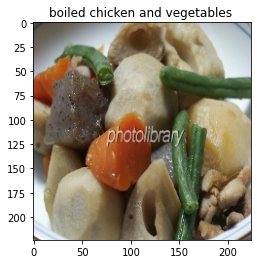

In [4]:
elem = x[list(x.keys())[26243]]
img = mpimg.imread(elem[0])
imgplot = plt.imshow(img)
rez = ''
for i in range(1, len(elem)):
    rez += labels['name'][elem[i] - 1] + ' '
plt.title(rez)
plt.show()

In [5]:
SHOULD_RESIZE = False
if SHOULD_RESIZE:
    for el in x.keys():
        ouput = cv2.resize(cv2.imread(x[el][0]), (224, 224))
        cv2.imwrite(x[el][0], ouput)

In [6]:
lista = []
lista_y = []
categs = []
counter = {}
for i in range(20):
    counter[i] = 60
for el in x.keys():
    if sum(counter.values()) == 0:
        break
    if x[el][1] in counter and counter[x[el][1]] > 0:
        lista.append(cv2.imread(x[el][0]))
        rez = []
        categs.append(x[el][1])
        for i in range(20):
            if i in x[el][1:]:
                rez.append(1)
            else:
                rez.append(0)
        lista_y.append(rez)
        counter[x[el][1]] -= 1
lista = np.array(lista)
lista_y = np.array(lista_y)

In [7]:
print(len(lista))
lista, val_lista, lista_y, val_lista_y = train_test_split(lista, lista_y, train_size=0.8)

1140


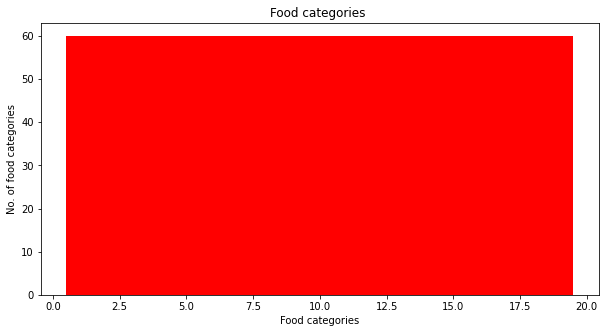

In [8]:
from collections import Counter
vals = Counter(categs)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(vals.keys(), vals.values(), color ='red',
        width = 1)
 
plt.xlabel("Food categories")
plt.ylabel("No. of food categories")
plt.title("Food categories ")
plt.show()

In [9]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
base_model.trainable = False
x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# and a logistic layer
predictions = Dense(20, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=15)

checkpointer = ModelCheckpoint(os.path.join('models', 'inceptionv3_' + 'multi-label' + '_best.h5'), verbose=1, save_best_only=True)

In [11]:
model.fit(lista, lista_y, epochs=30, callbacks=[early_stopping])
loss_value , accuracy = model.evaluate(val_lista, val_lista_y)

print('Test_loss_value = ' +str(loss_value))
print('test_accuracy = ' + str(accuracy))

Epoch 1/30
29/29 [==============================] - 65s 2s/step - loss: 9.3921 - accuracy: 0.0526
Epoch 2/30
29/29 [==============================] - 54s 2s/step - loss: 1.1961 - accuracy: 0.0844
Epoch 3/30
29/29 [==============================] - 50s 2s/step - loss: 0.4027 - accuracy: 0.0954
Epoch 4/30
29/29 [==============================] - 52s 2s/step - loss: 0.2511 - accuracy: 0.0954
Epoch 5/30
29/29 [==============================] - 52s 2s/step - loss: 0.2209 - accuracy: 0.1206
Epoch 6/30
29/29 [==============================] - 51s 2s/step - loss: 0.2025 - accuracy: 0.1360
Epoch 7/30
29/29 [==============================] - 51s 2s/step - loss: 0.2037 - accuracy: 0.1414
Epoch 8/30
29/29 [==============================] - 51s 2s/step - loss: 0.1972 - accuracy: 0.1787
Epoch 9/30
29/29 [==============================] - 54s 2s/step - loss: 0.1915 - accuracy: 0.1930
Epoch 10/30
29/29 [==============================] - 50s 2s/step - loss: 0.2176 - accuracy: 0.1535
Epoch 11/30
29/29 [